In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib
from scipy.optimize import curve_fit
from scipy.signal import find_peaks,savgol_filter
from scipy.stats import linregress
from scipy.constants import Boltzmann,c as light,u
import json
matplotlib.rc('axes.formatter', useoffset=False)
# %matplotlib atagg
# matplotlib.use('Qt5Agg')
plt.rcParams.update({'font.size': 10})

In [2]:
with open('kali.txt') as json_file:
    kali = json.load(json_file)
print(kali)
def lin_func(x,slope,intercept):
    return slope*x+intercept

{'0': [-0.0006831583189536933, 780.247753204327], '3': [-0.0006593473937488854, 780.247552537188], '4': [-0.0006557151961520067, 780.2473265396443], '5': [-0.0006487626584672954, 780.2472880580533], '6': [-0.0006303134830736428, 780.2472357235326]}


In [64]:
class Spek():
    def __init__(self,freq,cut=False):
        self.freq=freq
        path=f"data/doppler/{freq}freq.dat"
        self.time, self.U_piezo, self.U_fp, self.U_spek, self.intensity = np.genfromtxt(path).T
        # Piezo-Spannung muss noch mit vier multipliziert werden.
        self.U_piezo = 4 * self.U_piezo

        # Falls cut == True, werden die Daten auf eine steigende Flanke der Piezo-Spannung zugeschnitten.
        if cut:
            # Finden des Minimums und Maximums
            # Bei mehreren Minima und Maxima ist die hardgecodete Auswahl über den letzten Index echt unschön...
            min = find_peaks(-1.0*self.U_piezo,width=2000)[0][0]
            max = find_peaks(self.U_piezo,width=2000)[0][-1]

            self.time = self.time[min:max+1]
            self.U_piezo = self.U_piezo[min:max+1]
            self.U_fp = self.U_fp[min:max+1]
            self.U_spek = self.U_spek[min:max+1]
            self.intensity = self.intensity[min:max+1]
        self.time=self.time-self.time[0]
        self.lamb=lin_func(self.U_piezo,kali[str(freq)][0],kali[str(freq)][1])
        self.omega=2*np.pi*light/(self.lamb*1e-9)
        linreg=linregress(self.time[100:3500],self.U_spek[100:3500])
        self.U_spek+=-linreg.slope*self.time-linreg.intercept
    def func_gauss(self,nu,A,nu0,sigma):
        return A*np.exp(-(nu-nu0)**2/(2*sigma**2))
    def peaks(self):
        self.popt1,self.pcov1=curve_fit(self.func_gauss,self.omega[4000:4800],self.U_spek[4000:4800],p0=[-1,2.41417e15,1e9],maxfev=100000)
        self.popt2,self.pcov2=curve_fit(self.func_gauss,self.omega[4850:6000],self.U_spek[4850:6000],p0=[-1,2.414185e15,1e9],maxfev=100000)
        self.popt3,self.pcov3=curve_fit(self.func_gauss,self.omega[6500:8000],self.U_spek[6500:8000],p0=[-1,2.4142e15,1e9],maxfev=100000)
        self.peaks_i=find_peaks(-self.U_spek,prominence=0.1)[0]
    def plot(self,title=None):
        fig = plt.figure(figsize=(7, 5))
        gs = GridSpec(8, 5)
        fig1 = fig.add_subplot(gs[:, :])
        # fig1.set_title(f"Laser")
        fig1.set_ylabel(r'$U_\mathrm{Spektrum}$ in V')
        # fig1.set_xlabel("t in s")
        fig1.set_xlabel("$\omega$ in 1/s")
        # fig1.set_xlabel("t in s")
        plt.tight_layout()
        plt.plot(self.omega[self.a:self.b],self.U_spek[self.a:self.b],c="C0",label="Spektrum")
        plt.plot(self.omega,self.func_gauss(self.omega,self.popt2[0],self.popt2[1],self.popt2[2]),c="C2",label="Fit zum 2. Peak")
        plt.plot(self.omega,self.func_gauss(self.omega,self.popt1[0],self.popt1[1],self.popt1[2]),c="C3",label="Fit zum 1. Peak")
        plt.plot(self.omega,self.func_gauss(self.omega,self.popt3[0],self.popt3[1],self.popt3[2]),c="C4",label="Fit zum 3. Peak")
        
        # plt.plot(self.time[self.a:self.b],self.U_spek[self.a:self.b],c="C0",label="Spektrum")
        fig1.scatter(self.omega[self.peaks_i],self.U_spek[self.peaks_i],c="C1",label="Peaks")
        plt.legend()
        plt.savefig("figures/doppler_korigiert_omega_fit.pdf")
        plt.show()

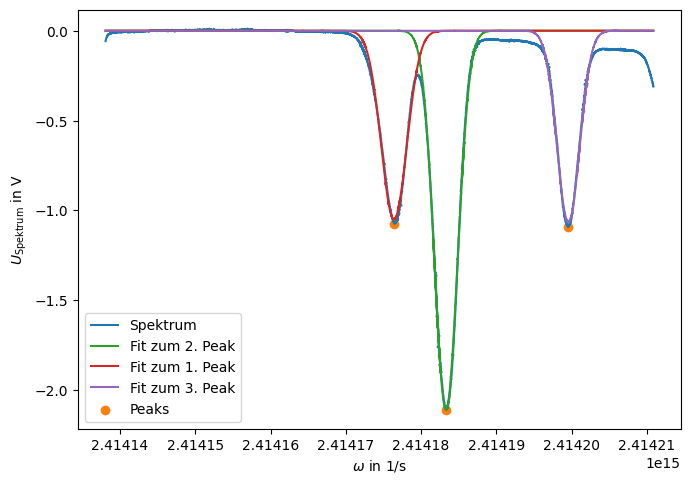

In [66]:
spek6=Spek(6,cut=True)
spek6.a,spek6.b=0,len(spek6.time)
# spek6.a,spek6.b=6500,8000
spek6.peaks()
spek6.plot()

In [67]:
fwhm1=2*np.sqrt(2*np.log(2))*spek6.popt1[2]
T1=np.square(light/(spek6.popt1[1])*fwhm1)*85*u/(8*Boltzmann*np.log(2))
fwhm2=2*np.sqrt(2*np.log(2))*spek6.popt2[2]
T2=np.square(light/(spek6.popt2[1])*fwhm2)*85*u/(8*Boltzmann*np.log(2))
fwhm3=2*np.sqrt(2*np.log(2))*spek6.popt3[2]
T3=np.square(light/(spek6.popt3[1])*fwhm2)*85*u/(8*Boltzmann*np.log(2))
print(T1,T2,T3)

460.51078866617655 378.39431445353654 378.38921822675127


In [59]:
peak_heigths_85=spek6.U_spek[spek6.peaks_i][0]+spek6.U_spek[spek6.peaks_i][1]
peak_heigths_87=spek6.U_spek[spek6.peaks_i][2]
quot=peak_heigths_87/peak_heigths_85
print(quot)
print(27.835/72.168)

0.3425481377494507
0.38569726194435205
